# Candidate Selection
The candidate selection process follows the logic below, find people that meet these criteria:
1. That have a single timezone such that there are no shifts in the time series, which will distort modelling and comparison.
2. That aren't missing any of the variables used, IOB, COB, IG across the dataset.
2. That have continuous data over a broad window that can capture overnight fasting, we will set arbitrarily to 19:00-12:00.
3. Periods will then be excluded if they lack IG for an hour or later, given this may impact analysis.
4. Following this, the minimum number of nights with such data for a candidate will be set arbitrarily to 100, providing a threshold for sufficient data.


In [90]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta, time, datetime
import numpy as np
from loguru import logger

from src.config import INTERIM_DATA_DIR
from src.configurations import Configuration, FifteenMinute
from src.helper import check_df_index, separate_flat_file, get_dfs_from_separated, filter_separated_by_ids
from src.candidate_selection import remove_null_variable_individuals, provide_data_statistics, plot_nights_vs_avg_intervals, Nights, reconsolidate_flat_file_from_nights
from src.data_processing.read_preprocessed_df import apply_and_filter_by_offsets, ReadPreprocessedDataFrame
from src.resample import resample_to_30_minute_intervals
from src.data_processing.read import read_profile_offsets_csv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:

fifteen_minute = FifteenMinute()
resampled_parquet_file = INTERIM_DATA_DIR / fifteen_minute.file_name('parquet')  # Pipeline output file

config = Configuration()
# The following dtype and index setting should be fixed in the next execution of the pipeline - 2025/06/09
dtypes = {'id': int, 'iob count': int, 'cob count': int, 'bg count': int}
df_origin = pd.read_parquet(resampled_parquet_file).drop(columns='system').astype(dtypes)
df_origin = df_origin.set_index(['id','datetime'])
df_origin = check_df_index(df_origin)
df_origin.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 685122 entries, (np.int64(221634), Timestamp('2018-03-16 20:30:00')) to (np.int64(99908129), Timestamp('2018-02-01 04:45:00'))
Data columns (total 15 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   iob mean   669370 non-null  Float32
 1   cob mean   644780 non-null  Float32
 2   bg mean    685122 non-null  Float32
 3   iob min    669370 non-null  Float32
 4   cob min    644780 non-null  Float32
 5   bg min     685122 non-null  Float32
 6   iob max    669370 non-null  Float32
 7   cob max    644780 non-null  Float32
 8   bg max     685122 non-null  Float32
 9   iob std    337473 non-null  Float32
 10  cob std    328312 non-null  Float32
 11  bg std     344576 non-null  Float32
 12  iob count  685122 non-null  int64  
 13  cob count  685122 non-null  int64  
 14  bg count   685122 non-null  int64  
dtype

The step will check and remove anyone that is missing all data for any of IOB, COB, BG columns, using the count columns.

In [54]:
check_cols = ['iob count', 'cob count', 'bg count']
ids_with_only_nans_or_zeros = {}
for col in check_cols:
    mask = (
        df_origin.groupby('id')[col]
        .apply(lambda x: x.isna().all() or (x.fillna(0) == 0).all())
    )
    ids_with_only_nans_or_zeros[col] = mask[mask].index.tolist()
print(ids_with_only_nans_or_zeros)

ids = set()
for key, val in ids_with_only_nans_or_zeros.items():
    ids.update(set(val))
print(ids)

{'iob count': [], 'cob count': [49551394], 'bg count': []}
{49551394}


How many full days does each individual have? A full day is defined as having 96 15-minute intervals. The following filters based on that.

In [55]:
full_days = df_origin.groupby('id', group_keys=False).size() // 96
mask_full_days = full_days.sort_values(ascending=False) > 100
df = df_origin.reset_index().set_index(['id','datetime']).sort_index()
mask = df.index.get_level_values('id').isin(mask_full_days[mask_full_days].index)
print(f'People with > 100 days in the dataset: {len(df[mask].index.get_level_values("id").unique())}')

People with > 100 days in the dataset: 19


However, full days aren't what we focus on, we need to identify periods between a start time on one day and an end-time the next morning, such that we can limit the period of focus, e.g. 19:00 - 11:00. The following are functions created for this purpose. The idea being that it will split the dataset into an array of dataframes for each night for an individual, and we can then analyse the nights. Firstly, we need to separate the dataframes for individuals, then we build a class to separate and analyse the nights for an individual.


In [72]:
df_tuple_by_id = separate_flat_file(df)
print(f'Number of dfs: {len(df_tuple_by_id)}')
individual = df_tuple_by_id[0]

Number of dfs: 114


In [57]:
args = {'zip_id': individual[0], 'df': individual[1], 'sample_rate':15}
nights = Nights(**args)
print(f'Preliminarily separated nights: {len(nights.get_nights())}')
nights.remove_incomplete_nights()
print(f'Following the removal of complete nights: {len(nights.get_nights())}')

Preliminarily separated nights: 104
Following the removal of complete nights: 0


Total intervals in the night period: 68
Total minutes in the period: 1020


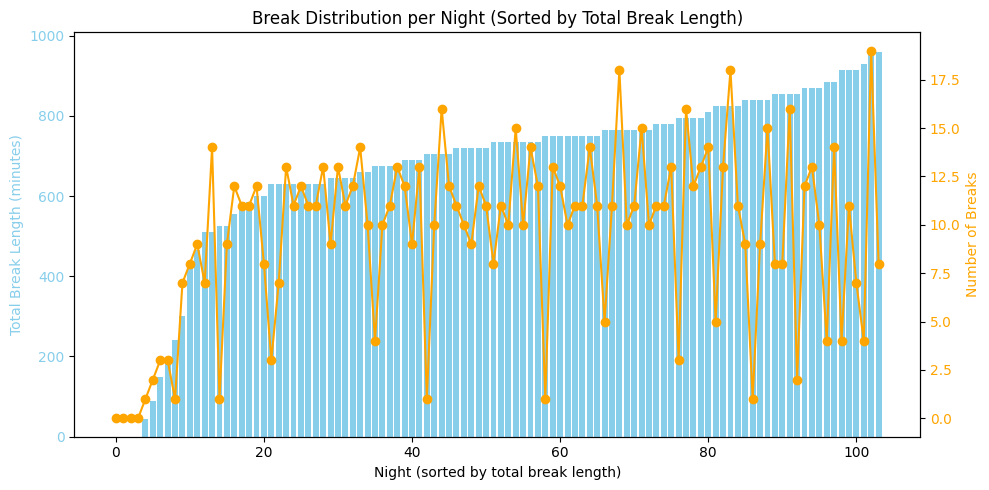

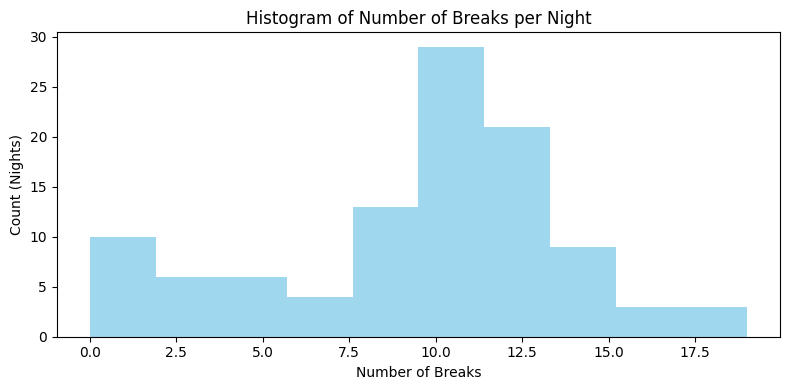

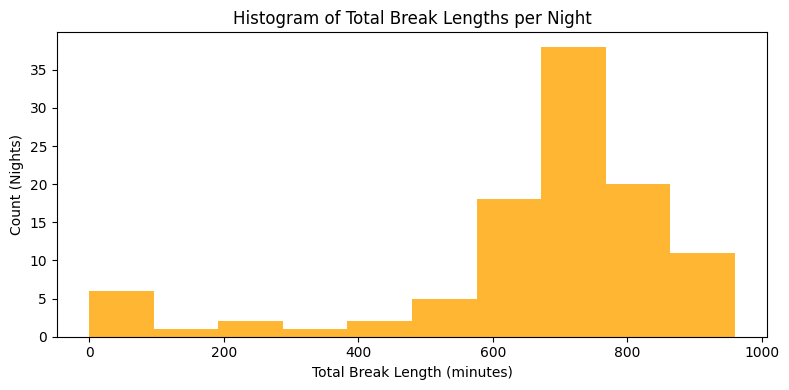

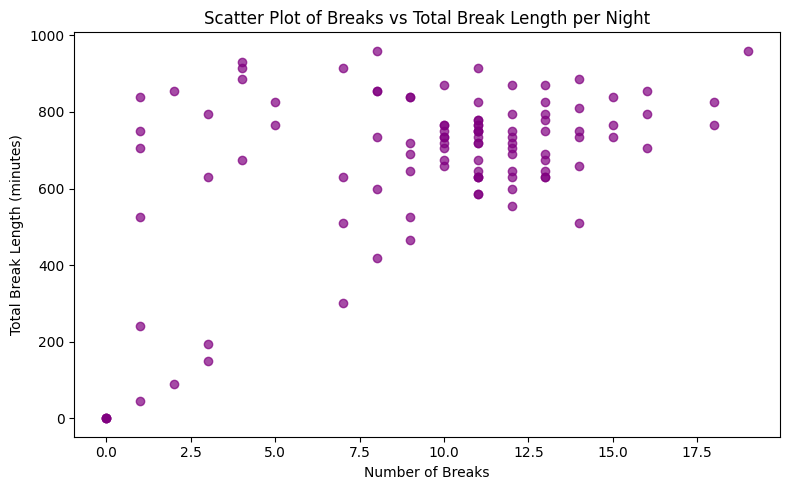

In [58]:
nights = Nights(**args)
print(f'Total intervals in the night period: {nights.total_intervals()}')
print(f'Total minutes in the period: {nights.total_minutes()}')
nights.plot_break_distribution()
nights.plot_break_histograms()
nights.plot_breaks_scatter()

Its clear with this individual that if we are concerned with the level of data over a night period and were to set an arbitrary limit of 10% loss of time covered (due to breaks in the data) then we end up with only a handful of people. Lets take a look at the whole population and see how they compare.

In [59]:
overall_stats_list = []
for id_val, df_individual in df_tuple_by_id:
    nights = Nights(zip_id=id_val, df=df_individual, sample_rate=15)
    stats = nights.overall_stats
    if stats:  # skip if stats is None
        stats['id'] = id_val
        stats['period_total_intervals'] = nights.total_intervals()
        stats['period_total_minutes'] = nights.total_minutes()
        overall_stats_list.append(stats)

df_overall_stats = pd.DataFrame(overall_stats_list)
df_overall_stats = df_overall_stats.set_index('id')
df_overall_stats.sort_values('complete_nights', ascending=False)


No stats per night have been calculated for 15634563. Returning no output.


,count_of_nights,complete_nights,avg_num_intervals,avg_missed_intervals,avg_num_breaks,avg_break_length,avg_max_break_length,avg_total_break_length,missed_interval_vectors,period_total_intervals,period_total_minutes
id,,,,,,,,,,,
17161370,970,4,53.631959,14.439175,6.050515,43.223724,79.886598,250.608247,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,...",68,1020
14092221,549,1,54.868852,13.728597,6.744991,38.859484,64.617486,258.114754,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",68,1020
47750728,71,1,52.788732,16.084507,7.014085,37.428678,70.352113,270.211268,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,...",68,1020
79526193,261,1,56.038314,11.961686,6.022989,41.368374,77.586207,239.482759,"[[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,...",68,1020
309157,18,0,1.055556,67.611111,0.055556,6.666667,6.666667,6.666667,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",68,1020
...,...,...,...,...,...,...,...,...,...,...,...
98974339,61,0,57.622951,10.377049,6.360656,35.000195,54.590164,221.311475,"[[0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",68,1020
99296581,10,0,48.500000,19.500000,8.900000,44.195833,105.000000,372.000000,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",68,1020
99712241,83,0,43.975904,25.951807,5.566265,63.761976,133.734940,316.265060,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,...",68,1020


NOTE: THE FOLLOWING COMMENT IS BASED ON THE FACT THAT THESE AREN'T YET LOCALISED:
There is a mixed picture here in terms of these different attributes that we could look to choose from. We want to maximise the number of complete nights, which can be easily determined, yet we don't want to exclude other nights that would also be useful. We really need to overlay at this point who our filtered set of people are that only have a single timezone as this will undoubtedly constrain us further.

WE NOW NEED TO LOCALISE BY OFFSETTING TIMEZONES, THEN ESTABLISH AND PLOT THE STATS ON THE SINGLE TIMEZONE SAMPLE.

So the following will be our order of processing to process the data and establish useful visualisations at each stage:
1. Import the preprocessed data
2. Apply offsets to that data
3. Remove null variable (IOB, COB, IG) individuals
4. Split the dataset (src.helper.separate_flat_file)
5. Process through the Nights class to:
    a) Separate individuals night data based on parameters
    b) Calculate stats on the individual's data completeness
6. Aggregate stats and visualise plot of individual's data

In [60]:
dtypes = {'id': int, 'iob count': int, 'cob count': int, 'bg count': int}
df_origin = pd.read_parquet(resampled_parquet_file).drop(
    columns='system').astype(dtypes)
df_origin = df_origin.set_index(['id', 'datetime'])
df_origin = check_df_index(df_origin)
df_offsets = pd.read_csv(INTERIM_DATA_DIR / 'profile_offsets.csv').astype(
    int).set_index('id')
df_processed = apply_and_filter_by_offsets(offsets_df=df_offsets,
                                           interim_df=df_origin)
df_processed = remove_null_variable_individuals(df_processed)
separated = separate_flat_file(df_processed)
df_overall_stats = provide_data_statistics(separated)

2025-06-13 16:31:50.936 | INFO     | src.candidate_selection:apply_and_filter_by_offsets:321 - IDs missing in offsets_df: {98974339, 35533061, 78420229, 66019205, 68026248, 40997757, 32997134, 1352464, 17161370, 49551394, 37998755, 40237051, 25692073, 74077367, 14092221, 18991425, 35719805, 43589707, 897741, 66937570, 65143138, 60844515, 27819368, 56958831, 80796147, 40634871, 16975609, 20396154, 81099003, 28176124, 86286077}
2025-06-13 16:31:52.104 | INFO     | src.candidate_selection:remove_null_variable_individuals:349 - Following individuals have one or more variables missing: set()
No stats per night have been calculated for 15634563. Returning no output.


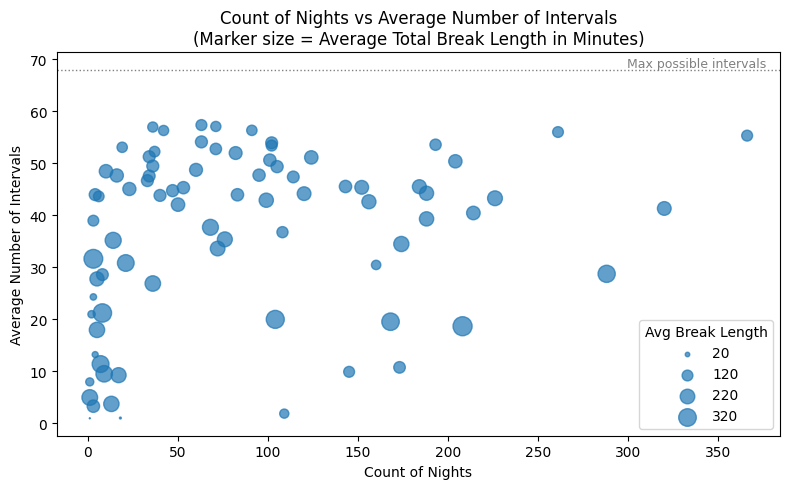

In [61]:
plot_nights_vs_avg_intervals(df_overall_stats)

So, from the data it appears that we are possibly going to have to use data that has missing intervals across the period. Hidden Markov Models may not be quite as effective in this regard, unless there are patterns in the missing value for someone, which might imply that we can use a state for the missing data. For someone to have predictable patterns would be considered to have low entropy, which measures the randomness of the missing data. High entropy describes very random missing intervals. In the following section, we will now look at how we can see if such patterns exist for people and try to find a way to compare people.

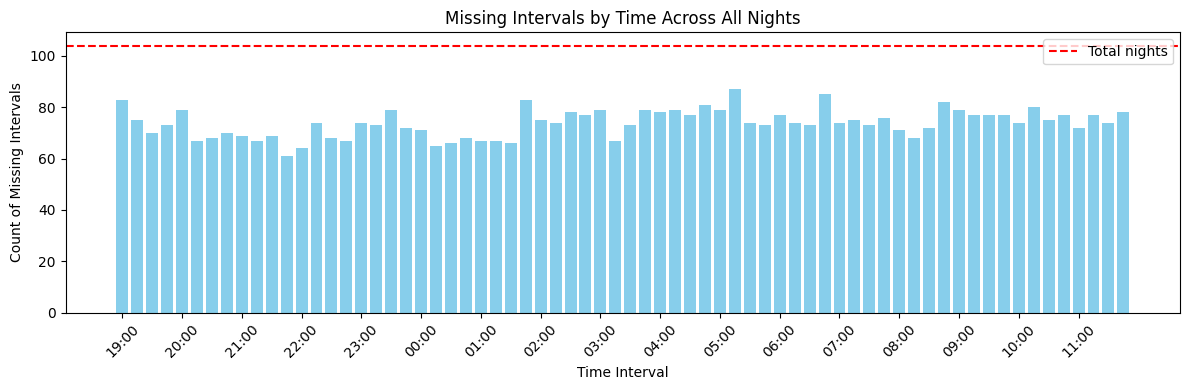

In [62]:
nights = Nights(**args)
nights.plot_missing_intervals_histogram()


In this instance, it is obvious that the data is simply far too sparse to use anyway, even through the missing values are not random, they are simply missing. This is a good example of how we can use the data to determine if it is suitable for analysis. We will need to look at other individuals to see if there are any that have more complete data, or at least more consistent data, such that we can use it for analysis. Lets filter the list to one with max complete nights, plus one with the highest average intervals per night, and see how they compare.

In [63]:
lowest_avg_missed_intervals = df_overall_stats.sort_values('avg_missed_intervals', ascending=True).iloc[0]
print(f'Lowest average missed intervals: \n{lowest_avg_missed_intervals}\n')



Lowest average missed intervals: 
count_of_nights                                                           63
complete_nights                                                            0
avg_num_intervals                                                  57.380952
avg_missed_intervals                                               10.619048
avg_num_breaks                                                      6.253968
avg_break_length                                                   39.280509
avg_max_break_length                                                69.52381
avg_total_break_length                                            246.428571
missed_interval_vectors    [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
period_total_intervals                                                    68
period_total_minutes                                                    1020
Name: 66836068, dtype: object



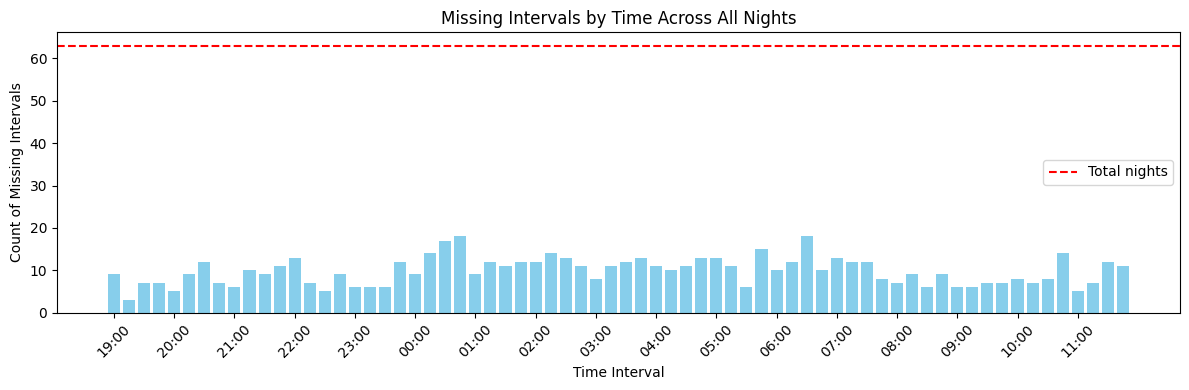

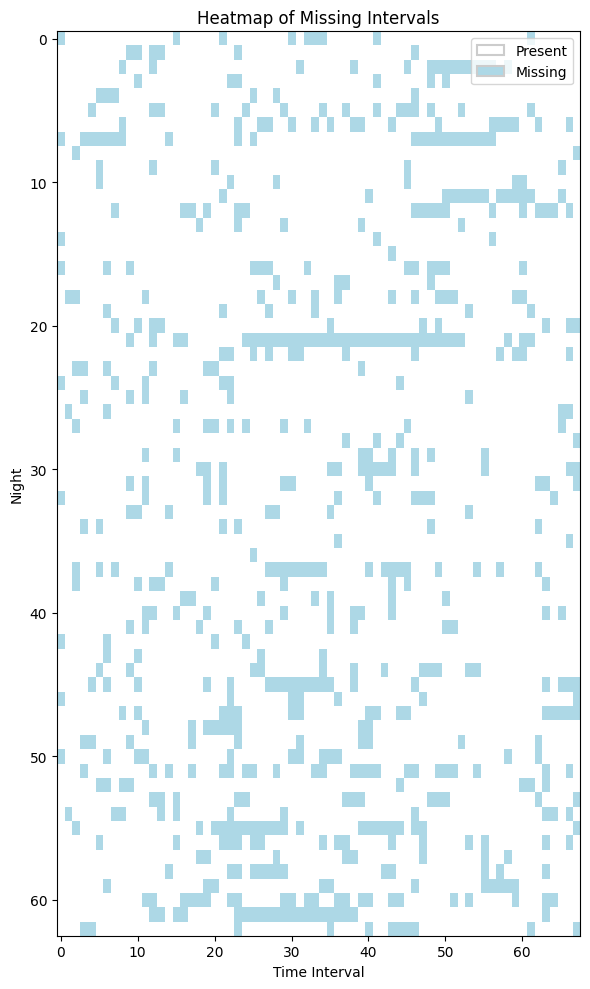

In [64]:
df_lowest_avg_missed_intervals = get_dfs_from_separated(separated, lowest_avg_missed_intervals.name)
nights = Nights(zip_id=lowest_avg_missed_intervals.name, df=df_lowest_avg_missed_intervals, sample_rate=15)
nights.plot_missing_intervals_histogram()
nights.plot_missingness_heatmap()


In this case, its not clear to see any clear patterns in the missing intervals. However, the vast majority are single intervals, which could be improved by resampling to 30 minute intervals. This would reduce the resolution of the data but would also reduce the number of missing intervals. This is a trade-off that we will have to consider when processing the data. Let look at resampling to 30-minut intervals and see how that changes the outlook.

In [65]:
df_30min_origin = resample_to_30_minute_intervals(df_origin)

2025-06-13 16:32:11.186 | INFO     | src.candidate_selection:apply_and_filter_by_offsets:321 - IDs missing in offsets_df: {98974339, 35533061, 78420229, 66019205, 68026248, 40997757, 32997134, 1352464, 17161370, 49551394, 37998755, 40237051, 25692073, 74077367, 14092221, 18991425, 35719805, 43589707, 897741, 66937570, 65143138, 60844515, 27819368, 56958831, 80796147, 40634871, 16975609, 20396154, 81099003, 28176124, 86286077}
2025-06-13 16:32:12.063 | INFO     | src.candidate_selection:remove_null_variable_individuals:349 - Following individuals have one or more variables missing: set()
No stats per night have been calculated for 15634563. Returning no output.


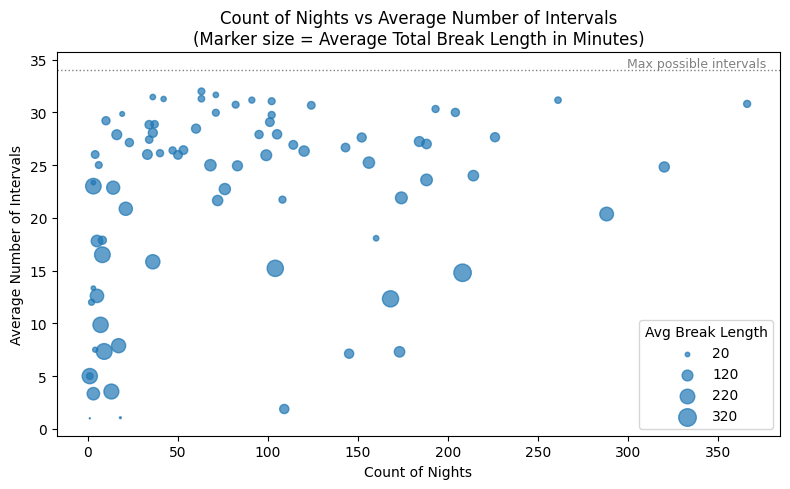

In [66]:
df_30min = apply_and_filter_by_offsets(offsets_df=df_offsets,
                                           interim_df=df_30min_origin)
df_30min = remove_null_variable_individuals(df_30min)
separated = separate_flat_file(df_30min)
df_overall_stats = provide_data_statistics(separated, sample_rate=30)
plot_nights_vs_avg_intervals(df_overall_stats)

This looks more promising, but we need to know how much so. Lets compare the heatmap for that individual, for a visual comparison.

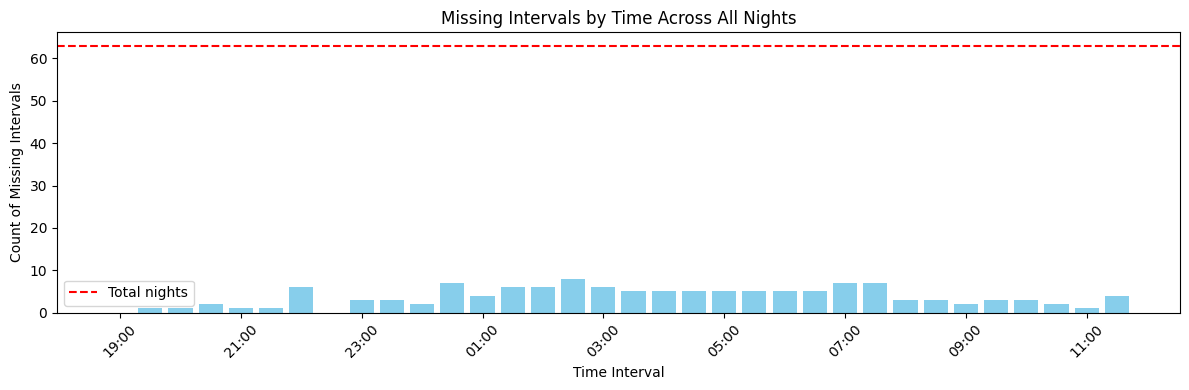

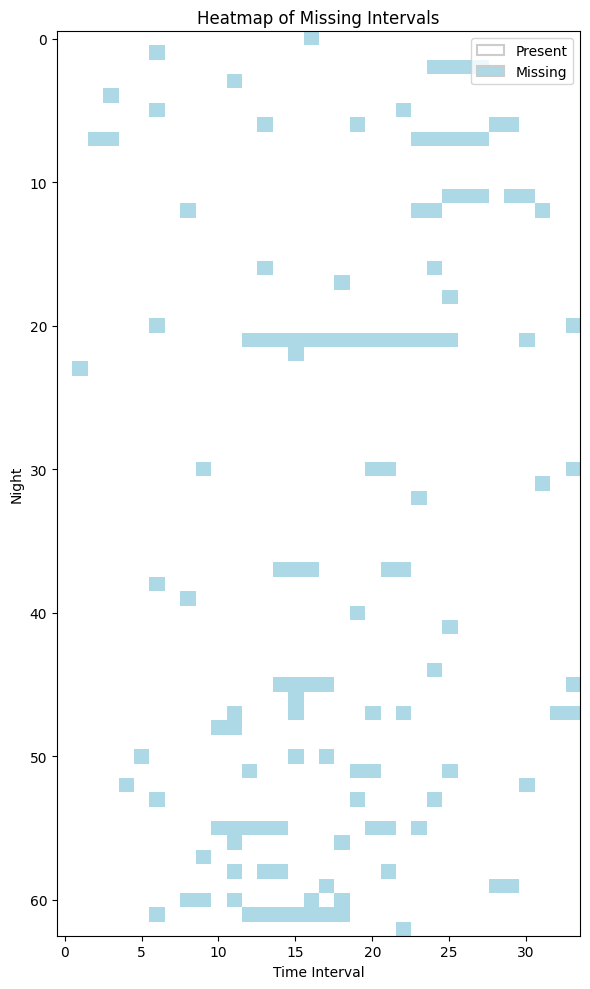

In [67]:
df_individual_30min = get_dfs_from_separated(separated, lowest_avg_missed_intervals.name)
nights_30min = Nights(zip_id=lowest_avg_missed_intervals.name, df=df_individual_30min, sample_rate=30)
nights_30min.plot_missing_intervals_histogram()
nights_30min.plot_missingness_heatmap()

Now let's have a look at how this is across all our group to see the amount of complete nights, defined by having 100% of intervals in the night period.

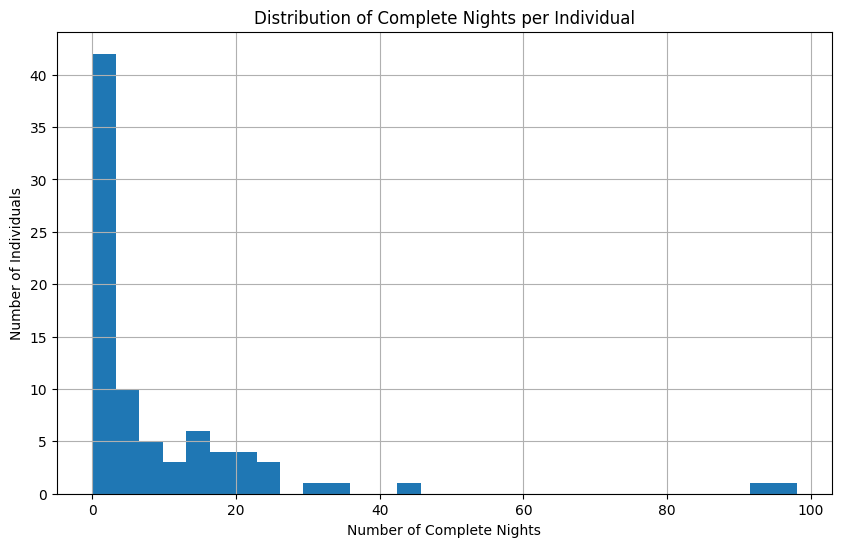

Number of individuals with > 30 complete nights: 5
Total number of complete nights across individuals with > 30 complete nights: 301


In [68]:
plt.figure(figsize=(10, 6))
df_overall_stats['complete_nights'].hist(bins=30)
plt.xlabel('Number of Complete Nights')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Complete Nights per Individual')
plt.show()

print(f'Number of individuals with > 30 complete nights: {len(df_overall_stats[df_overall_stats["complete_nights"] > 30])}')
print(f'Total number of complete nights across individuals with > 30 complete nights: {df_overall_stats[df_overall_stats["complete_nights"] > 30]["complete_nights"].sum()}') 

So, finally, we are in the realm of data that is workable with candidates that have a satisfactory level of completeness. To summarise the candidate selection process, we have:
1. Resampled the data to 30-minute intervals to reduce the number of missing intervals.
2. Applied offsets to the data to ensure that all individuals are in the same timezone.
3. Removed individuals that have no data for any of the variables used, IOB, COB, IG.
4. Split the data into individual dataframes for each person.
5. Processed the data through the Nights class to separate nights and calculate stats on the individual's data completeness.
6. Aggregated stats and visualised the data to understand the completeness of the data across individuals.
7. Identified individuals with a satisfactory level of completeness, defined as having more than 30 complete nights, which is a threshold we set based on the data available.
8. Returning complete nights data for the selected candidates.

This is now in the candidate_pipeline.py file, which can be used to run the candidate selection process in the future. The next step will be to use this data to build a feature extraction pipeline that can be used to extract features from the data for further analysis and modelling. First, lets look at the data visualised for each individual, to see how it looks.

In [113]:
# Pipeline to get the data wanted
# 0. Import the preprocessed data
fifteen_minute = FifteenMinute()
config = Configuration()
night_start = time(17, 0)  # 7 PM
morning_end = time(11, 0)  # 12 PM next day
new_sample_rate = 30  # Resampling to 30-minute intervals
df = ReadPreprocessedDataFrame(fifteen_minute, file_type='parquet').df
df_offsets = read_profile_offsets_csv(config)

# 1. Resample to 30-minute intervals
df = resample_to_30_minute_intervals(df)

# 2. Apply offsets to the data
df = apply_and_filter_by_offsets(offsets_df=df_offsets, interim_df=df)

# 3. Remove individuals with null variables
df_processed = remove_null_variable_individuals(df)

# 4. Separate the data into individual dataframes
separated = separate_flat_file(df_processed)

# 5. Process the data through the Nights class
df_overall_stats = provide_data_statistics(separated, sample_rate=new_sample_rate,
                                           night_start=night_start,
                                           morning_end=morning_end)

# 6. Aggregate stats and visualise the data - skipped

# 7. Identify individuals with satisfactory level of completeness
df_filtered = df_overall_stats[df_overall_stats['complete_nights'] > 30]

candidates = df_filtered.index.tolist()
logger.info(candidates)

# 8. Get only the complete nights for the candidates for further analysis
filtered_separated = filter_separated_by_ids(separated, candidates)
nights_objects = []
for id_, df in filtered_separated:
    nights = Nights(zip_id=id_, df=df,
                    night_start=night_start, morning_end=morning_end,
                    sample_rate=new_sample_rate)
    nights_objects.append(nights.remove_incomplete_nights())
    logger.info(f'Candidate: {id_}, Complete Nights: '
                f'{nights.overall_stats["complete_nights"]}')

df_all_selected = reconsolidate_flat_file_from_nights(nights_objects)

2025-06-14 18:13:48.489 | INFO     | src.data_processing.read_preprocessed_df:apply_and_filter_by_offsets:94 - IDs missing in offsets_df: {98974339, 35533061, 78420229, 66019205, 68026248, 40997757, 32997134, 1352464, 17161370, 49551394, 37998755, 40237051, 25692073, 74077367, 14092221, 18991425, 35719805, 43589707, 897741, 66937570, 65143138, 60844515, 27819368, 56958831, 80796147, 40634871, 16975609, 20396154, 81099003, 28176124, 86286077}
2025-06-14 18:13:49.290 | INFO     | src.candidate_selection:remove_null_variable_individuals:349 - Following individuals have one or more variables missing: set()
No stats per night have been calculated for 15634563. Returning no output.
2025-06-14 18:13:58.301 | INFO     | __main__:<module>:34 - [41131654, 67208817, 79526193, 86025410]
2025-06-14 18:13:58.728 | INFO     | __main__:<module>:44 - Candidate: 41131654, Complete Nights: 76
2025-06-14 18:13:58.848 | INFO     | __main__:<module>:44 - Candidate: 67208817, Complete Nights: 35
2025-06-14 1

In [119]:
from src.time_series_analysis import plot_night_means_for_individual

# Cycle through candidates and plot for each
for zip_id in candidates:
    plot_night_means_for_individual(df_all_selected, zip_id, night_start=night_start.hour, morning_end=morning_end.hour)

TypeError: Index must be a MultiIndex

In [112]:
df_offsets[df_offsets.index.isin(candidates)]

,offset
id,
28768536,-7
41131654,12
67208817,-4
79526193,-4
86025410,-4


In [ ]:
df_overall_stats